In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
base_path = '/Users/freezylex/Documents/course_work'
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

## Upload target

In [2]:
target_path = 'data/final_target.xlsx'
target = pd.read_excel(os.path.join(base_path, target_path), index_col = 'Date',
                       parse_dates=True)
target.drop(columns=['SU26217RMFS', 'SU26218RMFS'], inplace=True)
target.head(2)

,SU26214RMFS,SU26215RMFS,SU26216RMFS,SU26203RMFS,SU26204RMFS,SU26205RMFS,SU26206RMFS,SU26207RMFS,SU26208RMFS,SU26209RMFS,SU26210RMFS,SU26211RMFS,SU26212RMFS
Date,,,,,,,,,,,,,
2015-03-02,-71.009402,-16.198293,-51.672678,213.214039,8.877833,-69.514138,81.363229,81.611366,-44.294101,-46.555882,-65.581271,-32.632524,103.025743
2015-03-03,7.255880,45.041981,17.967756,263.188637,62.406383,10.363783,125.481830,112.795674,22.874165,26.012453,9.625523,34.752162,129.932953


## Upload metrics

In [3]:
metric_path = os.path.join(base_path, 'data/metrics_final')

rvi = pd.read_csv(os.path.join(metric_path, 'rvi.csv'), index_col = 'Date', parse_dates = True).loc['2015-06-01':]
cds = pd.read_csv(os.path.join(metric_path, 'cds.csv'), index_col = 'Date', parse_dates = True).loc['2015-06-01':]
usdrub = pd.read_csv(os.path.join(metric_path, 'usdrub.csv'), index_col = 'Date', parse_dates = True).loc['2015-06-01':]
BA = pd.read_csv(os.path.join(metric_path, 'BA.csv'), index_col = 'Date', parse_dates = True)
TC = pd.read_csv(os.path.join(metric_path, 'TC.csv'), index_col = 'Date', parse_dates = True)
PD = pd.read_csv(os.path.join(metric_path, 'PD.csv'), index_col = 'Date', parse_dates = True)
TR = pd.read_excel(os.path.join(metric_path, 'till_redemption.xlsx'), index_col = 'Date', parse_dates = True)

## Join 

In [4]:
available_indexes = list((set(rvi.index) & set(cds.index) & \
                          set(usdrub.index) & set(BA.index) & set(target.index)))
available_indexes = np.sort(np.array(available_indexes))

In [5]:
target = target.loc[available_indexes]

rvi = rvi.loc[available_indexes]
cds = cds.loc[available_indexes]
usdrub = usdrub.loc[available_indexes]
BA = BA.loc[available_indexes]
TC = TC.loc[available_indexes]
PD = PD.loc[available_indexes]
TR = TR.loc[available_indexes]

## Create dataset

In [6]:
id_ = np.arange(1, len(target.columns) + 1)
id_ = np.tile(id_, cds.shape[0])

complete_data = pd.DataFrame(columns = ['id', 'time', 'bond', 'log_PD', 
                                        'log_BA', 'log_TC', 'RVI', 'CDS','USDRUB','target'])
complete_data['id'] = id_
complete_data['time'] = np.repeat(BA.index, repeats=13) #number of bonds
complete_data

,id,time,bond,log_PD,log_BA,log_TC,RVI,CDS,USDRUB,target
0,1,2015-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2015-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2015-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2015-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2015-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1815,9,2016-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816,10,2016-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1817,11,2016-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1818,12,2016-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
transfer = {'SU26214RMFS':1, 
            'SU26215RMFS':2, 
            'SU26216RMFS':3, 
            'SU26203RMFS':4,
            'SU26204RMFS':5, 
            'SU26205RMFS':6, 
            'SU26206RMFS':7, 
            'SU26207RMFS':8,
            'SU26208RMFS':9, 
            'SU26209RMFS':10, 
            'SU26210RMFS':11, 
            'SU26211RMFS':12,
            'SU26212RMFS':13}

def make_feature(df, feature_name):
    global complete_data
    for column in df.columns:
        bond_data = df[column]
        try: #Костыль, так как в текущем датасете нет одного бонда
            number = transfer[column]
            for date in bond_data.index:
                complete_data.loc[(complete_data['id'] ==number)&(complete_data['time'] == date), feature_name] = bond_data.loc[date]
        except:
            pass
            
list_with_dfs = [('log_PD', PD), 
                 ('log_TC', TC), 
                 ('log_BA', BA),
                 ('TR', TR),
                 ('target', target)]

for feature, dataframe in tqdm(list_with_dfs):
    make_feature(dataframe, feature)

100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


In [8]:
complete_data['bond'] = np.tile(target.columns.values, reps=BA.shape[0])

complete_data['RVI'] = np.repeat(rvi['RVI'].values, repeats=len(target.columns))
complete_data['RVI_struct_coef'] = np.repeat(rvi['struct_coef'].values, repeats=len(target.columns))
complete_data['struct_change_Jan'] = np.repeat(rvi['dummy_struct_change'].values, repeats=len(target.columns))

complete_data['CDS_dummy'] = np.repeat(cds['CDS_dummy_struct'].values, repeats=len(target.columns))
complete_data['CDS'] = np.repeat(cds['CDS1Y'].values, repeats=len(target.columns))
complete_data['CDS_new_slope'] = np.repeat(cds['CDS_struct_coef'].values, repeats=len(target.columns))

complete_data['USDRUB'] = np.repeat(usdrub['USDRUB_CBR'].values, repeats=len(target.columns))
complete_data['oil_shock_1st_USDRUB_dummy'] = np.repeat(usdrub['dummy_1_oil_shock'].values, repeats=len(target.columns))
complete_data['oil_shock_1st_USDRUB_coef'] = np.repeat(usdrub['USDcoef_oil_shock_1'].values, repeats=len(target.columns))

short_term_indicator = [0,0,0,1,0,0,1,0,0,0,0,0,0]
short_term_indicator = np.tile(short_term_indicator, reps=target.shape[0])
complete_data['short_term_bond'] = short_term_indicator

complete_data['const'] = 1

In [9]:
complete_data.head(1)

,id,time,bond,log_PD,log_BA,log_TC,RVI,CDS,USDRUB,target,TR,RVI_struct_coef,struct_change_Jan,CDS_dummy,CDS_new_slope,oil_shock_1st_USDRUB_dummy,oil_shock_1st_USDRUB_coef,short_term_bond,const
0,1,2015-06-02,SU26214RMFS,-0.793177,4.007151,2.70805,38.34,227.12,52.8213,79.195092,4.989041,0.0,0,0,0.0,1,52.8213,0,1


In [10]:
complete_data['LT_BA'] = BA[BA.columns[13:]].values.ravel(order='C')
complete_data['LT_PD'] = PD[PD.columns[13:]].values.ravel(order='C')
complete_data['LT_TC'] = TC[TC.columns[13:]].values.ravel(order='C')

In [11]:
complete_data.drop(columns=['bond'], inplace=True)
complete_data = complete_data.set_index(['id', 'time'])
complete_data = complete_data.groupby(level=0).diff().dropna(axis='rows')
complete_data

,,log_PD,log_BA,log_TC,RVI,CDS,USDRUB,target,TR,RVI_struct_coef,struct_change_Jan,CDS_dummy,CDS_new_slope,oil_shock_1st_USDRUB_dummy,oil_shock_1st_USDRUB_coef,short_term_bond,const,LT_BA,LT_PD,LT_TC
id,time,,,,,,,,,,,,,,,,,,,
1,2015-06-03,-3.837416,-0.095328,-0.068993,1.32,-11.06,0.6200,-8.575632,-0.00274,0.00,0.0,0.0,0.00,0.0,0.62,0.0,0.0,0.0,1.0,0.0
2,2015-06-03,-1.115806,-1.792426,1.252763,1.32,-11.06,0.6200,-8.434159,-0.00274,0.00,0.0,0.0,0.00,0.0,0.62,0.0,0.0,0.0,0.0,0.0
3,2015-06-03,-0.997205,-0.20061,0.087011,1.32,-11.06,0.6200,-6.734977,-0.00274,0.00,0.0,0.0,0.00,0.0,0.62,0.0,0.0,0.0,0.0,0.0
4,2015-06-03,1.344392,-0.427789,-0.470004,1.32,-11.06,0.6200,-2.446923,-0.00274,0.00,0.0,0.0,0.00,0.0,0.62,0.0,0.0,0.0,0.0,0.0
5,2015-06-03,-0.066719,-0.222793,1.386294,1.32,-11.06,0.6200,-0.999225,-0.00274,0.00,0.0,0.0,0.00,0.0,0.62,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,2016-02-19,0.524332,0.105003,-0.504556,-1.38,-0.43,-2.3928,-3.386513,-0.00274,-1.38,0.0,0.0,-0.43,0.0,0.00,0.0,0.0,0.0,0.0,0.0
10,2016-02-19,-1.720924,-0.566034,-1.375823,-1.38,-0.43,-2.3928,-22.886262,-0.00274,-1.38,0.0,0.0,-0.43,0.0,0.00,0.0,0.0,0.0,0.0,0.0
11,2016-02-19,-0.487635,-0.534022,0.338113,-1.38,-0.43,-2.3928,-12.261613,-0.00274,-1.38,0.0,0.0,-0.43,0.0,0.00,0.0,0.0,0.0,0.0,0.0


In [12]:
complete_data = complete_data.reset_index()

In [13]:
train_sample = complete_data[complete_data['time'] <= '2016-02-01']
test_sample = complete_data[complete_data['time'] > '2016-01-29'] #for differencing

In [14]:
train_sample.to_excel(os.path.join(base_path, 'data/Macro_LM_FD_train.xlsx'))
test_sample.to_excel(os.path.join(base_path, 'data/Macro_LM_FD_test.xlsx'))

## Build up the model

In [15]:
from linearmodels.panel import FirstDifferenceOLS
from linearmodels.panel import PooledOLS
from linearmodels.panel import compare

In [16]:
exog_vars = ['CDS', 'CDS_new_slope', 'CDS_dummy', 'RVI', 'RVI_struct_coef','struct_change_Jan',
             'USDRUB','log_PD', 'LT_PD']
inverse_transfer = {}
for key, val in transfer.items():
    inverse_transfer[val] = key

In [17]:
def create_info_table(true_vals, predicted_vals, transformer_dict):
    info_table = true_vals.reset_index().merge(predicted_vals.reset_index(), on=['id', 'time'])
    info_table = info_table[['id', 'time', 'target', 'predictions']]
    info_table['target'] = info_table['target'].astype('float')
    info_table['predictions'] = info_table['predictions'].astype('float') #DataFrame with id, time, target and pred 
    #for the whole time-span of the train or test sample
    
    info_table['error'] = np.abs(info_table['target'] - info_table['predictions'])
    info_table['error_2'] = info_table['error'] ** 2
    summary_table = pd.concat([info_table.groupby('id').mean()[['error']], np.sqrt(info_table.groupby('id').mean()[['error_2']])], axis=1)
    summary_table.columns = ['MAE', 'RMSE']
    summary_table.index = list(transformer_dict.values())
    return info_table, summary_table



In [18]:
def build_model(train, test, model_class, 
                short_list, cov_type=None):
    '''
    Assumes that both train and test dataframes have 'target' column.
    '''
    ### TRAIN THE MODEL
    train = train.set_index(['id', 'time'])
    exog_vars_train = train[short_list]
    model_init = model_class(train.target, exog_vars_train)
    if cov_type:
        model = model_init.fit(cov_type=cov_type)
    else:
        model = model_init.fit()
    predictions_train = pd.DataFrame(model.fitted_values)
    predictions_train.rename(columns={'fitted_values':'predictions'}, inplace=True)
    
    ### TEST THE MODEL
    test = test.set_index(['id', 'time'])
    test_= test[short_list]
    predictions_test = model.predict(test_)
    
    info_train, summary_train = create_info_table(train, predictions_train, inverse_transfer)
    info_test, summary_test = create_info_table(test, predictions_test, inverse_transfer)
    return model, info_train, summary_train, info_test, summary_test

In [24]:
def make_plots(train, test, dir_to_save, dict_inv):
    dir_ = os.path.join(base_path, dir_to_save)
    if not os.path.exists(dir_):
        os.mkdir(dir_)
    whole_sample = pd.concat([train, test])
    for ind, obj in whole_sample.groupby('id'):
        fig, ax = plt.subplots(figsize=(15, 10))
        sns.lineplot(x = obj['time'], y = obj['target'], color='r', label='Target value', ax = ax)
        sns.lineplot(x = obj['time'], y = obj['predictions'], color='b', label='Model prediction', ax = ax)
        ax.grid()
        plt.ylabel('Spread between rates, b.p.')
        plt.xlabel('Date')
        ax.set_title(f'Target and prediction dynamics for bond {dict_inv[ind]}')
        ax.vlines(x=[datetime(2016, 2, 1)], ymin = min(min(obj['target']), min(obj['predictions'])),
                          ymax = max(max(obj['target']), max(obj['predictions'])))
        dir_temp = os.path.join(dir_, dict_inv[ind])
        plt.savefig(dir_temp, dpi=300)

In [20]:
fd_model, train_data, train_summary, \
test_data, test_summary = build_model(train_sample, test_sample, PooledOLS, exog_vars)

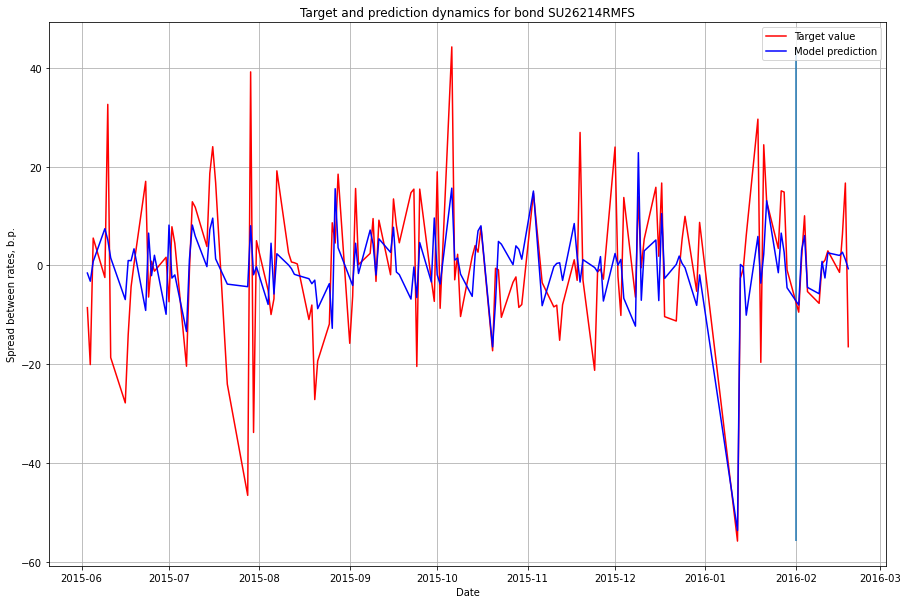

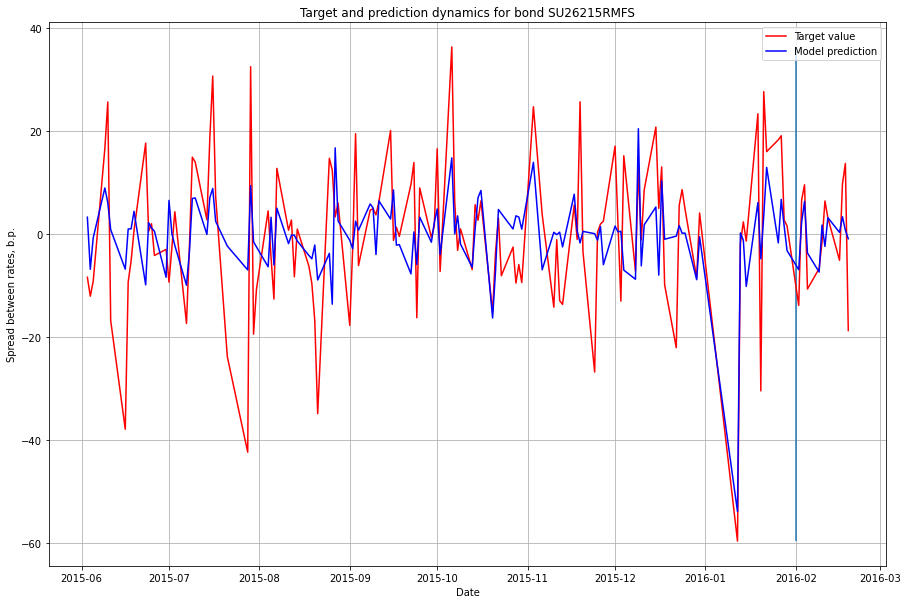

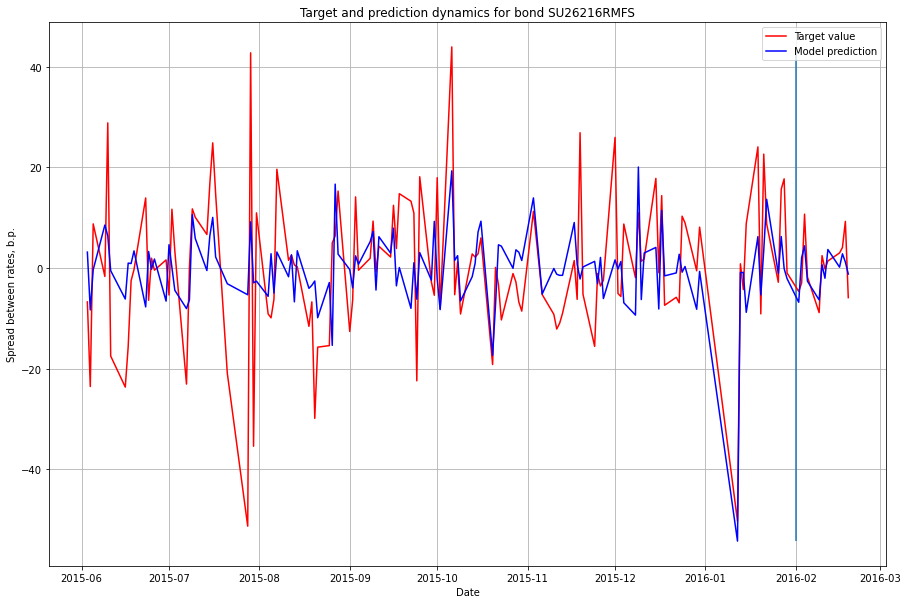

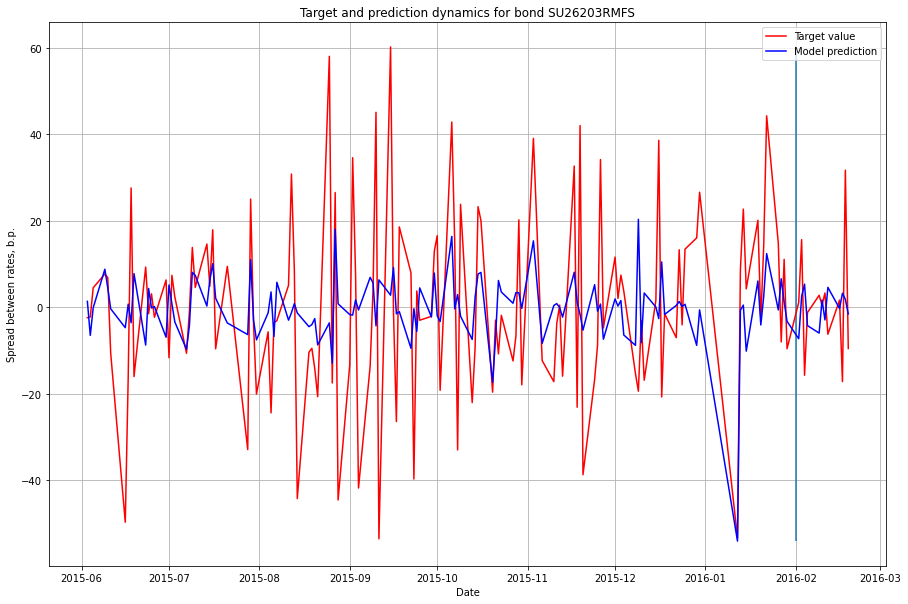

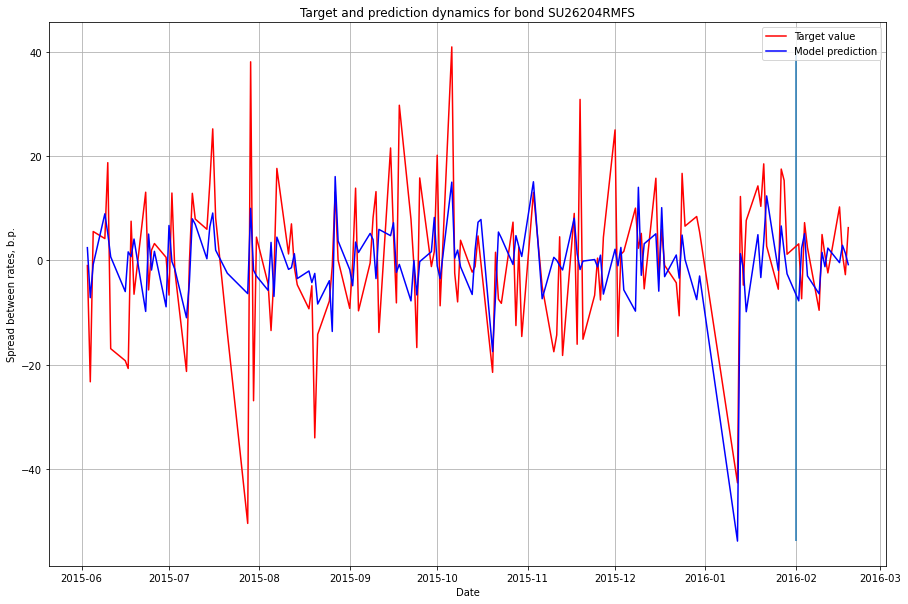

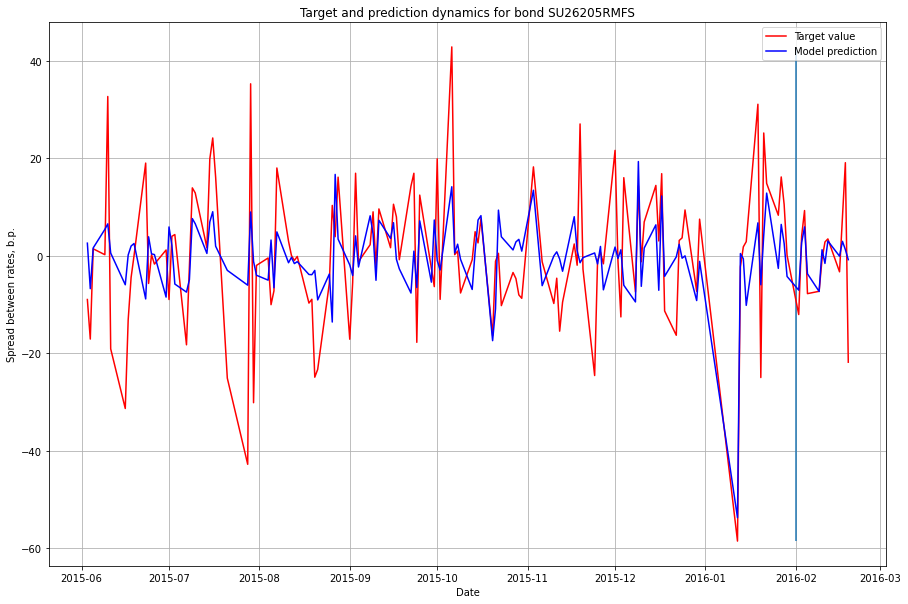

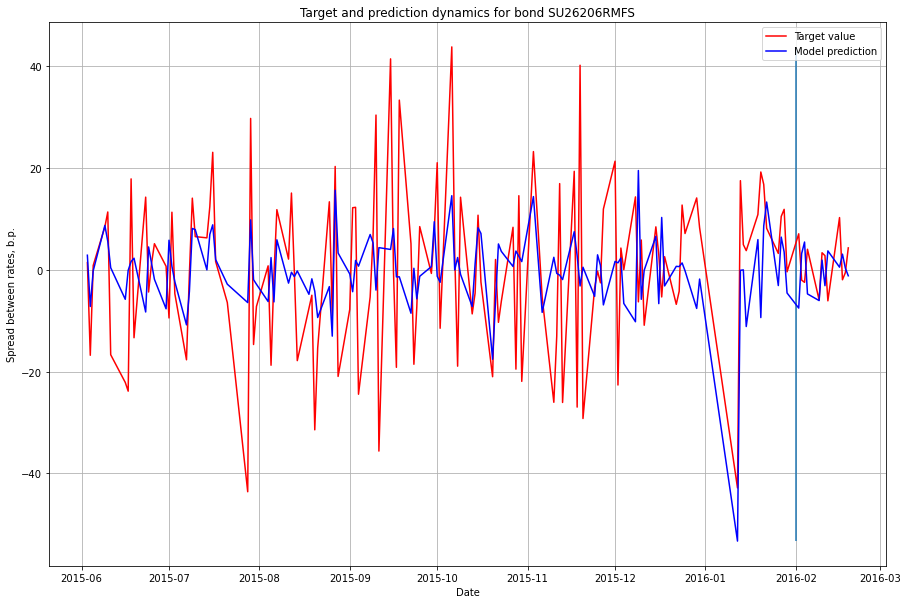

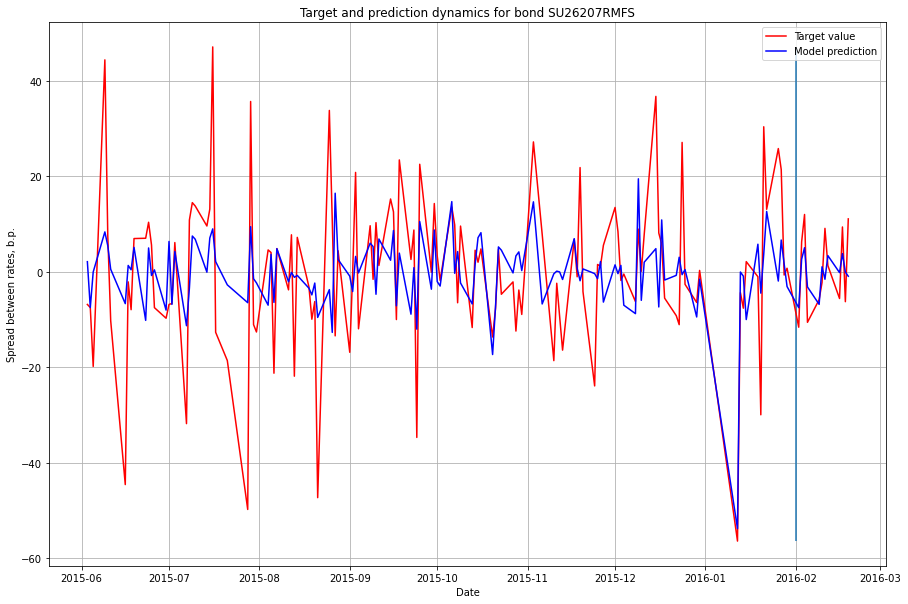

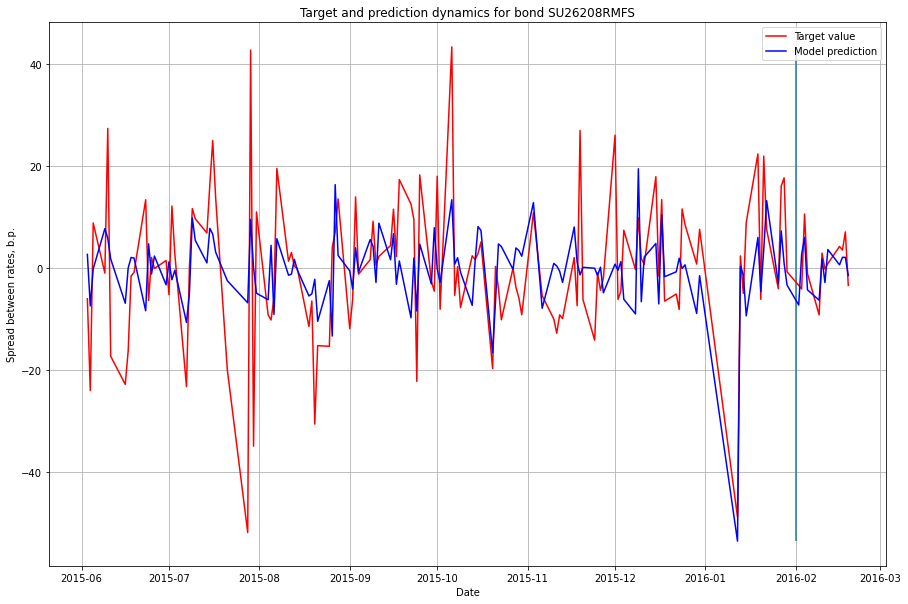

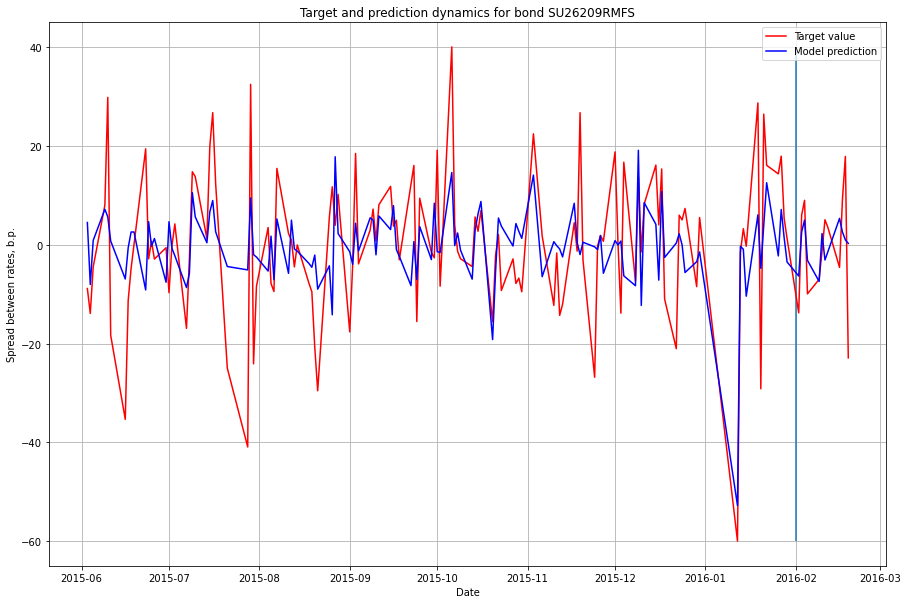

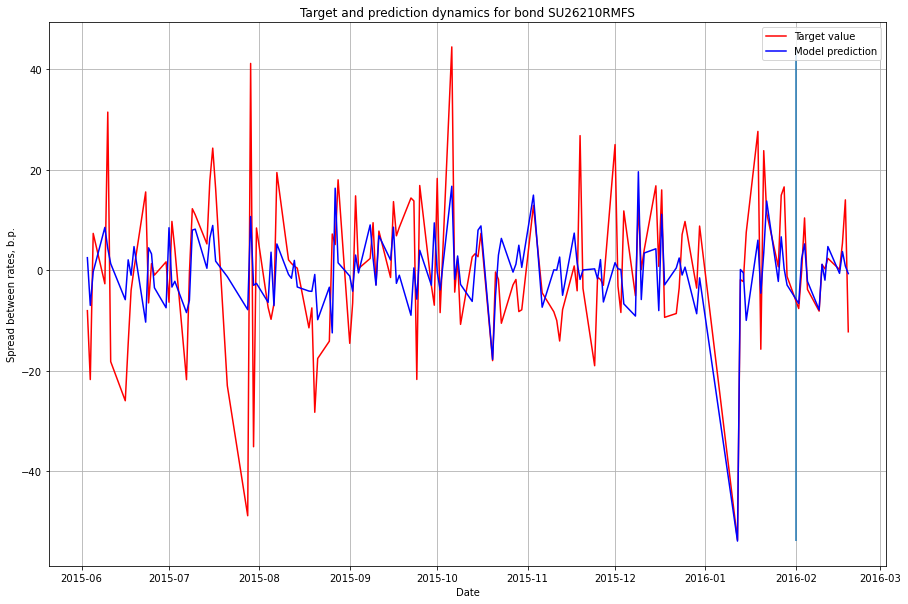

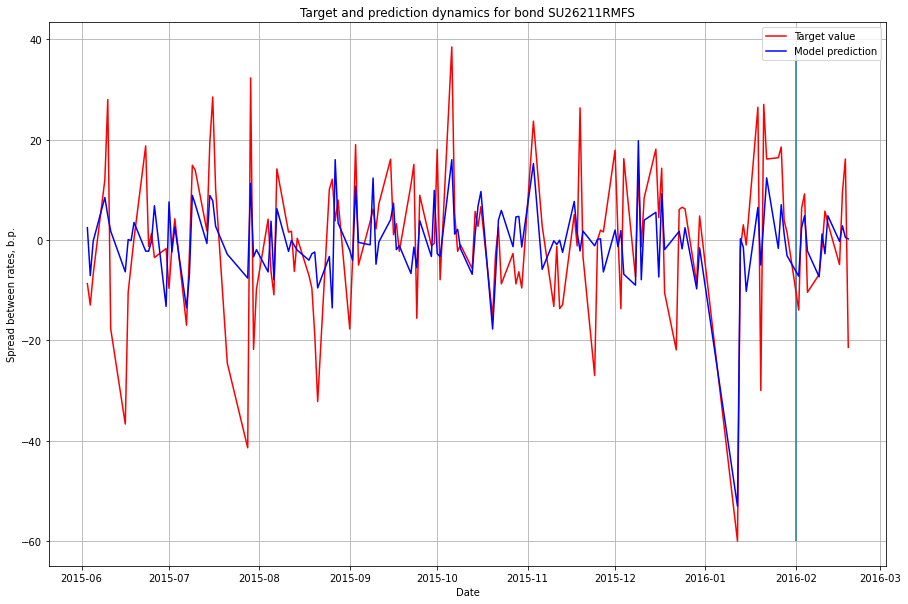

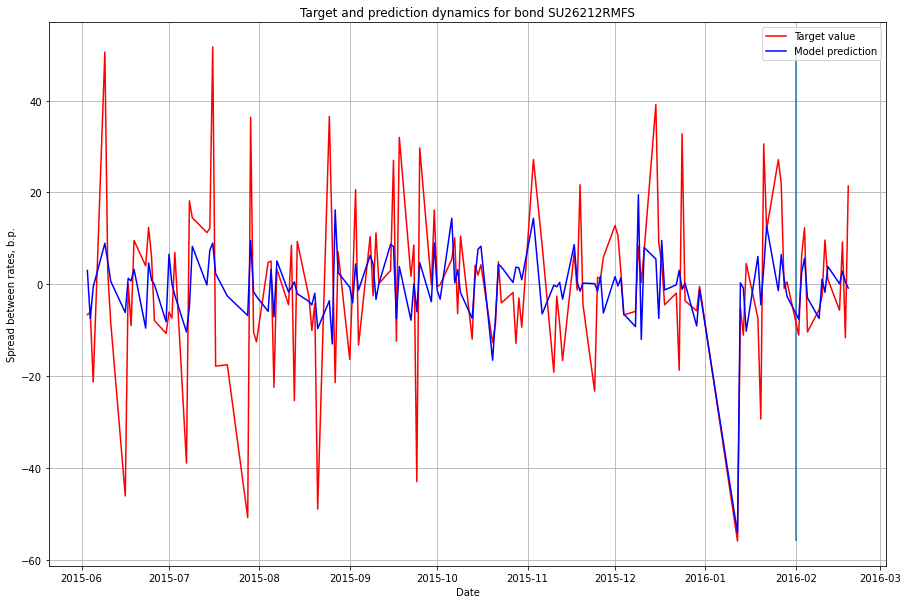

In [25]:
make_plots(train_data, test_data, 'graphs/FD_model', inverse_transfer)

In [26]:
fd_model

Dep. Variable:,target,R-squared:,0.2377
Estimator:,PooledOLS,R-squared (Between):,-1.2542
No. Observations:,1651,R-squared (Within):,0.2381
Date:,"Tue, Apr 12 2022",R-squared (Overall):,0.2377
Time:,00:59:35,Log-likelihood,-6687.3
Cov. Estimator:,Unadjusted,,
,,F-statistic:,56.884
Entities:,13,P-value,0.0000
Avg Obs:,127.00,Distribution:,"F(9,1642)"
Min Obs:,127.00,,
Max Obs:,127.00,F-statistic (robust):,56.884


# Comparison of models

In [27]:
RVI_vars = ['RVI', 'struct_change_Jan']
rvi_model, rvi_train_sample, train_rvi, rvi_test_sample, test_rvi = build_model(train_sample, test_sample, 
                                                                                PooledOLS, RVI_vars)

CDS_vars = ['CDS', 'CDS_new_slope', 'CDS_dummy']
cds_model, _, train_cds, _, test_cds = build_model(train_sample, test_sample, 
                                                   PooledOLS, CDS_vars)

USDRUB_vars = ['USDRUB', 'struct_change_Jan', 'oil_shock_1st_USDRUB_dummy']
usdrub_model, _, train_usdrub, _, test_usdrub = build_model(train_sample, test_sample, 
                                                            PooledOLS, USDRUB_vars)

rvi_cds_vars = RVI_vars + CDS_vars
rvi_cds, _, train_rvi_cds, _, test_rvi_cds = build_model(train_sample, test_sample, 
                                                         PooledOLS, rvi_cds_vars)

macro_ind_vars = ['RVI', 'struct_change_Jan', 'CDS', 'CDS_new_slope', 'CDS_dummy', 'USDRUB']
macro_ind, _, train_3_macro, _, test_3_macro = build_model(train_sample, test_sample,
                                                           PooledOLS, macro_ind_vars)

all_vars = macro_ind_vars + ['log_PD', 'LT_PD']
all_model, _, train_all, _, test_all = build_model(train_sample, test_sample, 
                                                   PooledOLS,  all_vars)

compare({"RVI index model": rvi_model, 
         "CDS 1Y model": cds_model, 
         "USDRUB model": usdrub_model,
         "RVI and CDS model": rvi_cds,
         "USDRUB, RVI and CDS model":macro_ind,
         "Final model": all_model})

,RVI index model,CDS 1Y model,USDRUB model,RVI and CDS model,"USDRUB, RVI and CDS model",Final model
Dep. Variable,target,target,target,target,target,target
Estimator,PooledOLS,PooledOLS,PooledOLS,PooledOLS,PooledOLS,PooledOLS
No. Observations,1651,1651,1651,1651,1651,1651
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted
R-squared,0.1691,0.1189,0.0920,0.2230,0.2293,0.2363
R-Squared (Within),0.1703,0.1188,0.0932,0.2241,0.2297,0.2368
R-Squared (Between),-3.9460,0.4321,-4.0857,-3.6650,-1.2812,-1.2309
R-Squared (Overall),0.1691,0.1189,0.0920,0.2230,0.2293,0.2363
F-statistic,167.77,74.125,55.643,94.466,81.567,63.562
P-value (F-stat),0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [28]:
def make_statistics_summary(dict_data):
    info_df_mae = pd.DataFrame(index = ['train sample', 'test sample'], columns = list(dict_data.keys()))
    info_df_rmse = pd.DataFrame(index = ['train sample', 'test sample'], columns = list(dict_data.keys()))
    for key in dict_data.keys():
        info_df_mae.loc['train sample', key] = dict_data[key][0].mean()['MAE']
        info_df_mae.loc['test sample', key] = dict_data[key][1].mean()['MAE']
        
        info_df_rmse.loc['train sample', key] = dict_data[key][0].mean()['RMSE']
        info_df_rmse.loc['test sample', key] = dict_data[key][1].mean()['RMSE']
    return info_df_mae, info_df_rmse

In [29]:
mae_mi, rmse_mi = make_statistics_summary({  "RVI index model": [train_rvi, test_rvi], 
                                             "CDS 1Y model": [train_cds, test_cds], 
                                             "USDRUB model": [train_usdrub, test_usdrub],
                                             "RVI and CDS model": [train_rvi_cds, test_rvi_cds],
                                             "USDRUB, RVI and CDS model":[train_3_macro, test_3_macro],
                                             "Final model": [train_all, test_all]})

### MAE statistics for all defined models

In [30]:
mae_mi

,RVI index model,CDS 1Y model,USDRUB model,RVI and CDS model,"USDRUB, RVI and CDS model",Final model
train sample,10.85706,11.147703,11.21422,10.513565,10.488163,10.451314
test sample,6.308796,6.686888,6.786418,6.384862,6.004935,6.050739


### RMSE statistics for all defined models

In [31]:
rmse_mi

,RVI index model,CDS 1Y model,USDRUB model,RVI and CDS model,"USDRUB, RVI and CDS model",Final model
train sample,14.291114,14.800616,15.01699,13.81676,13.759618,13.698517
test sample,8.121059,8.409334,8.259773,8.258101,7.767086,7.802642
